In [1]:
import os
import time
import datetime
import shutil # used to copy files
import warnings
#warnings.filterwarnings('ignore')  # force to ignore warnings

# load configuration setting
from utils import config

# Stage 0: Initialize settings

In [2]:
## Realization of config() class
# configurations are listed in ../config/config.yaml
config = config()

In [3]:
## Setup the path for saving the results
now = str(datetime.datetime.now())[:16].replace(":","_").replace("-","_").replace(" ","_")
sourcePath = config.path.dataPath
path = config.path.resultPath + str(now)
# Create a folder for saving the result
os.mkdir(path)
destinationPath = path+"/config.yaml"
shutil.copy(sourcePath,destinationPath)

'results/2020_06_06_00_25/config.yaml'

# Stage 1: Train the Target Model

### Step 0: Initialization

In [4]:
## Import packages
# PyTorch packages
import torch

In [5]:
## Sets the seed for generating random numbers
# Setting the random seed manually --> garantee each time has the same result of randomization.
torch.manual_seed(config.general.seed)

## Detect GPU and Set up device
use_cuda = config.general.use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Models are trained on: GPU" if use_cuda else "Models are trained on: CPU")

Models are trained on: GPU


### Step 1: Extract data records from dataset CIFAR10

In [6]:
from torchvision import transforms

# Set up the transformation of the dataset
transform=transforms.Compose([
                    #transforms.RandomCrop(32, padding=4),
                    #transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.4914,0.4822, 0.4465],std=[0.2023,0.1994,0.2010])
               ])

In [7]:
import torchvision
from torchvision.datasets import CIFAR10
import numpy as np
from PIL import Image

In [8]:
## Inherit and modify the official CIFAR10 class
class custumCIFAR10(CIFAR10):

    def __init__(self, isTargetModel, indexOfShadow, config, *args, **kwargs):
        """
        Arguments:
            isTargetModel(boolen): whether is target model's dataset
            indexOfShadow: if it is Shadow Models' dataset, the index of the shadow model
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        super().__init__(*args, **kwargs)
        self.config = config
        if self.train: # If it is going to train the model
            if isTargetModel: # For the target model
                # data records
                self.data = self.data[:config.general.targetTrainingSize]
                # data labels
                self.targets = self.targets[:config.general.targetTrainingSize]
            else: # For the shadow models
                overlapRate = config.evaluate.overlapRate
                shift = - int(overlapRate*config.general.targetTrainingSize)
                #print("Shift: " + str(shift))
                #self.data = self.data[config.general.targetTrainingSize+shift:]
                self.data = self.data[config.general.targetTrainingSize*(indexOfShadow+1)+shift:
                                      shift+config.general.targetTrainingSize*(indexOfShadow+2)]
                self.targets = self.targets[config.general.targetTrainingSize*(indexOfShadow+1)+shift:
                                            shift+config.general.targetTrainingSize*(indexOfShadow+2)]
        else: # If it is going to test the model
            if isTargetModel: # For the target model
                self.data = self.data[:config.general.targetTestSize]
                self.targets = self.targets[:config.general.targetTestSize]
            else: # For the shadow models
                #self.data = self.data[config.general.targetTestSize:]
                self.data = self.data[config.general.targetTestSize*(indexOfShadow+1):
                                      config.general.targetTestSize*(indexOfShadow+2)]
                self.targets = self.targets[config.general.targetTestSize*(indexOfShadow+1):
                                            config.general.targetTestSize*(indexOfShadow+2)]

    def __getitem__(self, index):
        """
        Arguments:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            index = index % self.config.general.targetTrainingSize
        else:
            index = index % self.config.general.targetTestSize
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [9]:
## Extract data record from dataset CIFAR10
# Arguments: isTargetModel, indexOfShadowModel, configuration, path, (downloadDataset),trainOrTest, transform.
targetTrainData = custumCIFAR10(True, 0, config, '../data', train=True, download=True, transform=transform)
targetTestData = custumCIFAR10(True, 0, config, '../data', train=False, transform=transform)

Files already downloaded and verified


### Step 2: Use PyTorch dataloader to load the data records for the Target Model 

In [10]:
## Load data for the target model
targetTrainLoader = torch.utils.data.DataLoader(targetTrainData,
                                          batch_size=config.learning.batchSize, 
                                          shuffle=True)
targetTestLoader = torch.utils.data.DataLoader(targetTestData,
                                          batch_size=config.learning.batchSize, 
                                          shuffle=True)

targetDataLoader = {"train": targetTrainLoader, "val": targetTestLoader}
targetDatasetSizes = {"train": len(targetTrainData), "val": len(targetTestData)}

### Step 3: Define & Load Network Architecture

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
## Define Network Architecture
# CNN2
class Net_cifar10_CNN2(nn.Module):
    def __init__(self):
        super(Net_cifar10_CNN2, self).__init__()
        # first convolutional layer: input channel * 3(RGB); output channel * 6; kernal size: 5*5 
        self.conv1 = nn.Conv2d(3, 6, 5)
        # first max pooling layer: kernal size: 2*2; stride: 2
        self.pool = nn.MaxPool2d(2, 2)
        # second convolutional layer: input channel * 6; output channel * 16; kernal size: 5*5 
        self.conv2 = nn.Conv2d(6, 16, 5)
        # first fully-connected layer - flatten the output from the final max-pooling layer
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        # (last fully-connected layer) output layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
# CNN3
class Net_cifar10_CNN3(nn.Module):
    def __init__(self):
        super(Net_cifar10_CNN3, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x #nn.Softmax(dim=1)(x)

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
def Net_cifar10_ResNet():
    return ResNet(ResidualBlock)

In [15]:
# Select the model based on the configuration 
modelType = config.learning.model
if modelType == "ResNet":
    Net_cifar10 = Net_cifar10_ResNet
if modelType == "CNN3":
    Net_cifar10 = Net_cifar10_CNN3
if modelType == "CNN2":
    Net_cifar10 = Net_cifar10_CNN2
    
## move the model to the computing device(GPU/CPU)
targetModel = Net_cifar10().to(device)

### Step 4: Define loss function, optimizer, and learning rate scheduler

In [16]:
import torch.optim as optim
from torch.optim import lr_scheduler # learning rate stragegy

In [17]:
# since we are classifying images into more than two classes 
# we will use cross-entropy as a loss function.
criterion = nn.CrossEntropyLoss()

# to optimize the network we will employ 
# stochastic gradient descent (SGD) with momentum to 
# help get us over local minima and saddle points in the loss function space.
optimizer = optim.SGD(targetModel.parameters(),
                      lr = config.learning.learningRate,
                      momentum = config.learning.momentum)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                       step_size=config.learning.decreaseStepSize,
                                       gamma=config.learning.decreaseFactor)

### Step 5: Train & Test the Target Model

In [18]:
import copy
from torchvision import datasets, models

def trainModel(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, numberOfEpochs=25):
    since = time.time() # record the starting time
    modelWeights = copy.deepcopy(model.state_dict())
    accuracy = 0
    trainingRecord = np.zeros((4,numberOfEpochs)) # Record the accuracy and loss v.s. epoches in training and test
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(numberOfEpochs):
        # Initialize lists
        PredictionVectors = [] # the output of the model
        InOrOutLabel = [] # Whether this instance comes from the training set 
        Class = [] # instance predicted label
        predLabel = [] # test set's predicted label
        actualLabel = [] # test set's ground truth label

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            # Initialize records of the losses and the number of correct predictions
            runLoss = 0.0
            runCorrects = 0
            # Iterate over data.
            for batch_idx, (data, target) in enumerate( dataloaders[phase]):
                inputs, labels = data.to(device), target.to(device)
                optimizer.zero_grad() # initialize --> set the gradients to be zero
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # forward propagation
                    # choose the class with the largest probability as the predicted label
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    # at the final epoch, evaluate the result
                    if epoch == numberOfEpochs-1:
                        for output in outputs.cpu().detach().numpy():
                            # put all the instances' prediction vector in a list
                            PredictionVectors.append(output)
                            if phase == "train":
                                InOrOutLabel.append(1) # 1 stands for being in the training set
                            else:
                                InOrOutLabel.append(0) # 0 stands for not being in the training set
                        for category in labels.cpu().detach().numpy():
                            Class.append(category)
                        # on the test set, record the predictions and truth labels 
                        if phase == 'val':
                            for predition in preds.cpu().detach().numpy():
                                predLabel.append(predition)
                            for label in labels.cpu().detach().numpy():
                                actualLabel.append(label)
                    # on the training set, backward propagate and optimize the model's parameters.
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # summarize and update loss and accuracy at the end of each batch
                runLoss += loss.item() * inputs.size(0)
                runCorrects += torch.sum(preds == labels.data)
            # summarize the loss and the accuracy at the end of each epoch
            epochLoss = runLoss / dataset_sizes[phase]
            epochAccuracy = runCorrects.double() / dataset_sizes[phase]
            if phase == 'train': # on the training set
                trainingRecord[0][epoch] = epochLoss
                trainingRecord[1][epoch] = epochAccuracy
            else: # on the test set
                trainingRecord[2][epoch] = epochLoss
                trainingRecord[3][epoch] = epochAccuracy
            # save the best model's parameters
            if phase == 'val' and epochAccuracy > accuracy:
                accuracy = epochAccuracy
                modelWeights = copy.deepcopy(model.state_dict())

    timeUsed = time.time() - since # calculate time used
    print('Complete training in {:.0f} minutes {:.0f} seconds'.format(timeUsed//60, timeUsed%60)) # format the time
    return model, trainingRecord, np.array(PredictionVectors), np.array(InOrOutLabel), np.array(Class), np.array(predLabel), np.array(actualLabel)

In [19]:
'''
The targetTrainingRecord consists of [loss on training set per epoch,
                                      accuracy on training set per epoch,
                                      loss on test set per epoch,
                                      accuracy on test set per epoch]
'''
targetModel, targetTrainingRecord, targetPredictionVectors, targetInOrOutLabel, targetClass, predLabelList, actualLabelList = trainModel(targetModel,
                                                                                                                           criterion,
                                                                                                                           optimizer,
                                                                                                                           exp_lr_scheduler,
                                                                                                                           targetDataLoader,
                                                                                                                           targetDatasetSizes,
                                                                                                                           numberOfEpochs=config.learning.epochs)

D:\Anaconda\envs\honor\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Complete training in 14 minutes 12 seconds


### Step 6: Save result for Attack Model

In [20]:
np.savetxt(path + "/targetTrainingRecord.txt", targetTrainingRecord)
np.savetxt(path + "/targetPredictionVectors.txt", targetPredictionVectors)
np.savetxt(path + "/targetInOrOutLabel.txt", targetInOrOutLabel)
np.savetxt(path + "/targetClass.txt", targetClass)
# Use np.loadtxt to load these files into numpy

### Step 7: Visualize some information about the result

In [21]:
import matplotlib.pyplot as plt

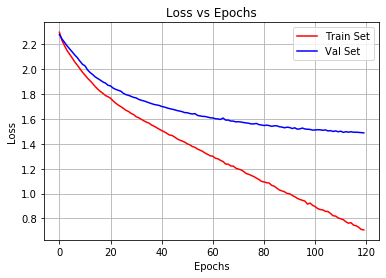

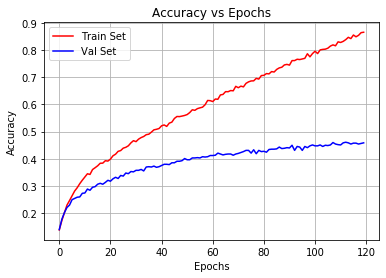

In [22]:
x = range(len(targetTrainingRecord[0]))
plt.plot(x,targetTrainingRecord[0],'-',color='r',label="Train Set")
plt.plot(x,targetTrainingRecord[2],'-',color='b',label="Val Set")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.savefig(path + "/LossVSEpochs.jpg")
plt.show()

plt.plot(x,targetTrainingRecord[1],'-',color='r',label="Train Set")
plt.plot(x,targetTrainingRecord[3],'-',color='b',label="Val Set")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid("both")
plt.savefig(path + "/AccuracyVSEpochs.jpg")
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

In [24]:
## Define the function to dram the Confusion Matrix
def plot_confusion_matrix(cm, classes, path, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path + "/CM.png")
    plt.show()

Normalized confusion matrix


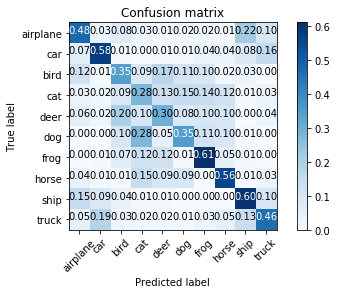

In [25]:
cm = confusion_matrix(actualLabelList, predLabelList)
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_confusion_matrix(cm=cm, classes=classes, path=path, normalize=True)

# Stage 2: Train the Shadow Models

In [26]:
ShadowAllModels = []
ShadowAllDataloaders = []
ShadowsPredictionVectors = []
ShadowsInOrOutLabels = []
ShadowsClasses = []

for IndexOfShadowModel in range(config.general.number_shadow_model):
    print("Start training Shadow Model No.{}".format(IndexOfShadowModel))
    # Extract data records from the data set
    shadowTrainData = custumCIFAR10(False, IndexOfShadowModel, config, '../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.4914,0.4822, 0.4465],std=[0.2023,0.1994,0.2010])
                   ]))
    shadowTestData = custumCIFAR10(False, IndexOfShadowModel, config, '../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                        transforms.Normalize(mean=[0.4914,0.4822, 0.4465],std=[0.2023,0.1994,0.2010])
                   ]))
    # Use dataloader to load the data records for training shadow models
    shadowTrainLoader = torch.utils.data.DataLoader(shadowTrainData, batch_size=config.learning.batchSize, shuffle=True)
    shadowTestLoader = torch.utils.data.DataLoader(shadowTestData, batch_size=config.learning.batchSize, shuffle=True)
    shadowDataloaders = {"train": shadowTrainLoader, "val": shadowTestLoader}
    shadowDatasetSizes = {"train": len(shadowTrainData), "val": len(shadowTestData)}
    # Set up the model on the device(GPU/CPU)
    shadowModel = Net_cifar10().to(device)
    # Define the loss function, optimizing strategy and learning rate scheduler.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(shadowModel.parameters(), lr=config.learning.learningRate, momentum=config.learning.momentum)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                           step_size=config.learning.decreaseStepSize,
                                           gamma=config.learning.decreaseFactor)
    shadowModel, shadowTrainingRecord, shadowPredictionVectors, shadowInOrOutLabels, shadowClasses, _, _ = trainModel(shadowModel,
                                                                                                                  criterion,
                                                                                                                  optimizer,
                                                                                                                  exp_lr_scheduler,
                                                                                                                  shadowDataloaders,
                                                                                                                  shadowDatasetSizes,
                                                                                                                  numberOfEpochs=config.learning.epochs)
    
    '''
    x = range(len(shadowTrainingRecord[0]))
    plt.plot(x,shadowTrainingRecord[0],'-',color='r',label="Train Set")
    plt.plot(x,shadowTrainingRecord[2],'-',color='b',label="Val Set")
    plt.legend()
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.savefig(path + "/LossVSEpochs.jpg")
    plt.show()

    plt.plot(x,shadowTrainingRecord[1],'-',color='r',label="Train Set")
    plt.plot(x,shadowTrainingRecord[3],'-',color='b',label="Val Set")
    plt.legend()
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid("both")
    plt.savefig(path + "/AccuracyVSEpochs.jpg")
    plt.show()
    '''
    
    ShadowsPredictionVectors.append(shadowPredictionVectors)
    ShadowsInOrOutLabels.append(shadowInOrOutLabels)
    ShadowsClasses.append(shadowClasses)
    ShadowAllModels.append(shadowModel)
    ShadowAllDataloaders.append(shadowDataloaders)
    np.savetxt(path + "/shadowTrainingRecord"+str(IndexOfShadowModel)+".txt", shadowTrainingRecord)

Start training Shadow Model No.0
Files already downloaded and verified


D:\Anaconda\envs\honor\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Complete training in 14 minutes 34 seconds
Start training Shadow Model No.1
Files already downloaded and verified
Complete training in 15 minutes 52 seconds
Start training Shadow Model No.2
Files already downloaded and verified
Complete training in 13 minutes 51 seconds
Start training Shadow Model No.3
Files already downloaded and verified
Complete training in 13 minutes 51 seconds
Start training Shadow Model No.4
Files already downloaded and verified
Complete training in 13 minutes 55 seconds
Start training Shadow Model No.5
Files already downloaded and verified
Complete training in 13 minutes 51 seconds
Start training Shadow Model No.6
Files already downloaded and verified
Complete training in 13 minutes 55 seconds
Start training Shadow Model No.7
Files already downloaded and verified
Complete training in 13 minutes 51 seconds
Start training Shadow Model No.8
Files already downloaded and verified
Complete training in 13 minutes 51 seconds
Start training Shadow Model No.9
Files alread

# Stage 3: Train the Attack Models

In [27]:
from sklearn.utils import shuffle

In [28]:
ShadowsPredictionVectors = np.concatenate(ShadowsPredictionVectors)
ShadowsInOrOutLabels = np.concatenate(ShadowsInOrOutLabels)
ShadowsClasses = np.concatenate(ShadowsClasses)
ShadowsPredictionVectors, ShadowsInOrOutLabels, ShadowsClasses = shuffle(ShadowsPredictionVectors,
                                                                         ShadowsInOrOutLabels,
                                                                         ShadowsClasses,
                                                                         random_state=config.general.seed)
targetPredictionVectors, targetInOrOutLabel, targetClass = shuffle(targetPredictionVectors,
                                                                   targetInOrOutLabel,
                                                                   targetClass,
                                                                   random_state=config.general.seed)

In [29]:
overlapRate = config.evaluate.overlapRate

np.savetxt(path + "\\" + str(overlapRate*100) + "ShadowsPredictionVectors.txt", ShadowsPredictionVectors)
np.savetxt(path + "\\" + str(overlapRate*100) + "ShadowsInOrOutLabels.txt", ShadowsInOrOutLabels)
np.savetxt(path + "\\" + str(overlapRate*100) + "ShadowsClasses.txt", ShadowsClasses)

In [30]:
restrictDataTrain = ShadowsPredictionVectors.copy()
restrictDataTest = targetPredictionVectors.copy()

In [31]:
# Set the smallest i items in the prediction vector to be 0
i = config.general.number_shadow_model

for j in range(len(restrictDataTrain)):
    restrictIndex = np.argsort(restrictDataTrain[j])[:i]
    for k in restrictIndex:
        restrictDataTrain[j][k] = 0

for j in range(len(restrictDataTest)):
    restrictIndex = np.argsort(restrictDataTest[j])[:i]
    for k in restrictIndex:
        restrictDataTest[j][k] = 0

In [32]:
print(ShadowsPredictionVectors[0])
print("Above vector is restricted to be only top " + str(i) + " available as followed:")
print(restrictDataTrain[0])

[ 2.3608341  1.4167799 -0.7492846 -2.261207  -2.3140092 -3.4595063
 -3.1075883 -2.2614062  4.389033   1.6717447]
Above vector is restricted to be only top 0 available as followed:
[ 2.3608341  1.4167799 -0.7492846 -2.261207  -2.3140092 -3.4595063
 -3.1075883 -2.2614062  4.389033   1.6717447]


In [33]:
import lightgbm as lgb # gradient boost machine
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [34]:
print("Size of Attack Model's Training Set:", len(ShadowsInOrOutLabels))
print("Size of Attack Model's Testing Set:", len(targetInOrOutLabel))

precisionPerClass, recallPerClass, accuracyPerClass = [], [], []
classes = [0,1,2,3,4,5,6,7,8,9]
predictedLabelAll = np.zeros(len(targetPredictionVectors))

for indexOfClass in classes:
    # Find out and group up data records with the same ground-truth label
    instanceWithSameClass = np.where(ShadowsClasses == indexOfClass)
    # For each group, train a unique attack sub-model
    model = lgb.LGBMClassifier(objective = 'binary', # binary classification problem, for the attack model
                               reg_lambda = config.learning.LGBM.reg_lambda,
                               n_estimators = config.learning.LGBM.n_estimators)
    model.fit(restrictDataTrain[instanceWithSameClass],  # prediction vectors
              ShadowsInOrOutLabels[instanceWithSameClass]) # in/out the training set
        # the attack model try to distinguish the differece of between the prediction vectors 
        # whose data is in the training set and not in the training set 
    # For each group, evaluate its cooresponding attack sub-model's performance
    instanceWithSameClass = np.where(targetClass == indexOfClass)
    predictedLabels = model.predict(restrictDataTest[instanceWithSameClass])
    precision, recall, _, _ = precision_recall_fscore_support(y_true=targetInOrOutLabel[instanceWithSameClass],
                                                              y_pred=predictedLabels,
                                                              average = "macro")
    accuracy = accuracy_score(y_true=targetInOrOutLabel[instanceWithSameClass], y_pred=predictedLabels)
    # Save the result
    precisionPerClass.append(precision)
    recallPerClass.append(recall)
    accuracyPerClass.append(accuracy)
    predictedLabelAll[instanceWithSameClass] = predictedLabels
    print("For Class {}, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(indexOfClass, precision, recall, accuracy))

Size of Attack Model's Training Set: 54000
Size of Attack Model's Testing Set: 5400
For Class 0, Precision: 0.7722, Recall: 0.6560, Accuracy: 0.8590
For Class 1, Precision: 0.6822, Recall: 0.6762, Accuracy: 0.8337
For Class 2, Precision: 0.7546, Recall: 0.6397, Accuracy: 0.8587
For Class 3, Precision: 0.7991, Recall: 0.7012, Accuracy: 0.8713
For Class 4, Precision: 0.6869, Recall: 0.6559, Accuracy: 0.8459
For Class 5, Precision: 0.7284, Recall: 0.6713, Accuracy: 0.8585
For Class 6, Precision: 0.6994, Recall: 0.6104, Accuracy: 0.8307
For Class 7, Precision: 0.6821, Recall: 0.5961, Accuracy: 0.8243
For Class 8, Precision: 0.8622, Recall: 0.6673, Accuracy: 0.8796
For Class 9, Precision: 0.7961, Recall: 0.7374, Accuracy: 0.8741


In [35]:
#  Calculate the overall performance of the attack model
precisionOverall, recallOverall, _, _ = precision_recall_fscore_support(y_true=targetInOrOutLabel,
                                                                        y_pred=predictedLabelAll,
                                                                        average = "macro")
accuracyOverall = accuracy_score(y_true=targetInOrOutLabel, y_pred=predictedLabelAll)   
print("Overall Performance, Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(precisionOverall,
                                                                                        recallOverall,
                                                                                        accuracyOverall))

Overall Performance, Precision: 0.7409, Recall: 0.6602, Accuracy: 0.8537


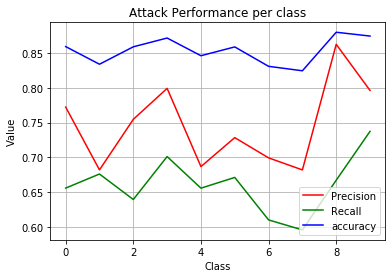

In [36]:
# Print the performance on each class
x = range(len(classes))
plt.plot(x,precisionPerClass,'-',color='r',label="Precision")
plt.plot(x,recallPerClass,'-',color='g',label="Recall")
plt.plot(x,accuracyPerClass,'-',color='b',label="accuracy")
plt.legend()
plt.title("Attack Performance per class")
plt.xlabel("Class")
plt.ylabel("Value")
plt.grid()
plt.savefig(path + "\\" + "attack.jpg")
plt.show()